<a href="https://colab.research.google.com/github/MScBusinessAnalytics2356723/Dissertation_CodeFile-Datasets/blob/main/CSR_Reports_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install and Import necessary libraries

In [1]:
pip install --upgrade ipykernel

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 4.7 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
  Attempting uninstall: ipykernel
    Found existing installation: ipykernel 5.5.6
    Uninstalling ipykernel-5.5.6:
      Successfully uninstalled ipykernel-5.5.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipykernel==5.5.6, but you have ipykernel 6.29.5 which is incompatible.


In [2]:
pip install PyMuPDF

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 66.9 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from nltk.tokenize import sent_tokenize
import fitz
import re

In [4]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Extract Text from Report PDFs and store in DFs

In [5]:
#File Paths
google_path='/content/drive/MyDrive/CSR_Reports/Google'
microsoft_path='/content/drive/MyDrive/CSR_Reports/Microsoft'

nvidia_path="/content/drive/MyDrive/CSR_Reports/NVIDIA"
samsung_path="/content/drive/MyDrive/CSR_Reports/Samsung"

tsmc_path="/content/drive/MyDrive/CSR_Reports/TSMC"


In [6]:
#Function to get length of a sentence to exclude smaller texts like image captions, labels or headings
def get_cnt(text):
    cnt = 0
    for word in text.split():
        if word.isalpha():
            cnt += 1
    return cnt

In [7]:
#Function to extarct only sentences logner than 5 words
def get_text(block_lst):

    MIN_WORD_CNT = 5

    text_lst = []
    for block in block_lst:
        if block[6] != 0: continue
        text = block[4]
        text = text.replace('fi ', 'fi')
        if get_cnt(text) < MIN_WORD_CNT: continue
        text_lst.append(text.replace('-\n', ''))

    return ('\n'.join(text_lst))

In [8]:
# Basic text cleaning - Remove special characters and convert text to lower case
def clean_text(text):

    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text.lower()

In [9]:
#Function to convert documents into individual sentences
def get_sentence(fname, skip_page = (1,2)):

    doc = fitz.open(fname)

    sent_lst = []
    for page_no, page in enumerate(doc):

        # Skip page- First 2 Pages(title and table of contents page)
        if page_no+1 in skip_page: continue

        #text=page.get_text()
        #print(text)
        block_lst = page.get_text('blocks')
        text = get_text(block_lst)


        for i, sentence in enumerate(sent_tokenize(text)):
          r_sent = ' '.join(sentence.split())
          r_sent = clean_text(r_sent)
          sent_lst.append(r_sent)

    doc.close()

    return sent_lst

In [10]:
#get_sentence("/content/drive/MyDrive/CSR_Reports/TSMC/TSMC_2017.pdf")

In [11]:
#Function to store the individual sentences in a dataframe
def gen_document(doc_id, fname, sent_lst):

    res_df = pd.DataFrame(
        {
            'doc_id': doc_id,
            'fname': fname,
            'sentence': sent_lst
        }
    )

    return res_df

In [12]:
#Function to Read PDF Files
def read_filelist(path):


    df = pd.DataFrame()


    for idx, fname in enumerate(os.listdir(path)):
        p_fname = os.path.join(path, fname)


        if p_fname.split('.')[-1] != 'pdf': continue

        doc_id = int(idx)


        sent_lst = get_sentence(p_fname)
        df_doc   = gen_document(doc_id, fname, sent_lst)

        df = pd.concat([df,df_doc])

    return df



In [13]:
#Read the CSR reports
google_df=read_filelist(google_path)
microsoft_df=read_filelist(microsoft_path)
nvidia_df = read_filelist(nvidia_path)
tsmc_df=read_filelist(tsmc_path)
samsung_df=read_filelist(samsung_path)



In [14]:
#nvidia_df.to_csv('NVIDIA_sentences.csv', index=False)
#tsmc_df.to_csv('TSMC_sentences.csv', index=False)
#samsung_df.to_csv('Samsung_sentences.csv', index=False)

#Explicit SDG Mentions

In [15]:
#Function to count frequnecy of SDG mentions in the CSR reports
sdg_terms=['sdg','sustainable development goals','sdgs']

def check_sdg_mentions(df,terms):
  count=0
  para=' '.join(df['sentence'])

  for phrase in terms:
        count += para.count(phrase)
  return count

def expl_sdg_func(df):

  df=df[['doc_id','fname','sentence']]
  df['year']=df['fname'].str.split(r'_|\(|\-|\.').apply(lambda x: x[1])

  company_count=pd.DataFrame(columns=['year','mentions'])

  data=[]
  for i in range(2017,2023):
    data.append({'year': i, 'mentions': check_sdg_mentions(df[df['year']==str(i)],sdg_terms)})


  company_count=pd.DataFrame(data)

  return company_count

#BDA, AI, ML terms

In [16]:
#Function to count frequency of BDA, AI, ML and related terms in the CSR reports

bda_terms=['ai','artificial intelligence','big data','big data analytics','analytics','machine learning','deep learning','forecasting','data mining','cloud computing','remote sensing']

def check_bda_mentions(df):
  count=0
  for phrase in bda_terms:
        count += df['sentence'].str.contains(r'\b'+phrase+ r'\b',regex=True).sum()
  return count

def expl_bda_func(df):

  df=df[['doc_id','fname','sentence']]
  df['year']=df['fname'].str.split(r'_|\(|\-|\.').apply(lambda x: x[1])

  company_bda_count=pd.DataFrame(columns=['year','mentions'])

  data=[]
  for i in range(2017,2023):
    data.append({'year': i, 'mentions': check_bda_mentions(df[df['year']==str(i)])})


  company_bda_count=pd.DataFrame(data)

  return company_bda_count

In [17]:
#Function to label a sentnece as containing a bda-related term
pattern = r'\b(?:' + '|'.join(bda_terms) + r')\b'
def sentence_bda_bool_check(df):

  df['contains_bda_term'] = df['sentence'].str.contains(pattern, case=False, regex=True)

  return df

##Topic Modeling

###BERTopic

In [18]:
pip install bertopic

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [19]:
#Clean text by removing stopwords- commonly occuring words like firm names, pronouns, connectors like 'the','and','but' etc. that do not contirbute to the analysis
def remove_stop(text):
  custom_stopwords = {'microsoft', 'nvidia','nvidias','csr','apple', 'google', 'amazon', 'taiwan semiconductors manufacturing company','tsmc', 'samsung','gpu','gpus'}
  #custom_stopwords = {'ai','artificial intelligence','big data','big data analytics','analytics','machine learning','deep learning','forecasting','data mining','cloud computing','remote sensing','microsoft', 'nvidia', 'apple', 'google', 'amazon', 'taiwan semiconductors manufacturing company','tsmc', 'samsung','gpu','gpus'}
  for phrase in custom_stopwords:
    text = text.replace(phrase, '')

  return text

In [20]:
#Function for topic modelling
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired,PartOfSpeech, MaximalMarginalRelevance

def bert_model(df):
  main_representation_model = KeyBERTInspired()

  topic_model = BERTopic(representation_model = main_representation_model)
  df['sentence'] = df['sentence'].apply(remove_stop)


  topics, probs = topic_model.fit_transform(df['sentence'])
  #topic_model.visualize_barchart(top_n_topics = 10, n_words = 10)

  return topic_model,probs

#Sentence Similarity with SDGs

In [21]:
#Read the SDG compass sentences
sdg_df=pd.read_excel("/content/drive/MyDrive/CSR_Reports/SDG_Compass_5Ps.xlsx")

In [22]:
#Clean text
sdg_df['sentence']=sdg_df['sentence'].astype(str)
sdg_df['sentence']=sdg_df['sentence'].apply(clean_text)

In [23]:
pip install sentence_transformers

In [24]:
#Function to calculate cosine similarity scores
from sentence_transformers import SentenceTransformer, util

def cosine_calc(df):

  model = SentenceTransformer('all-MiniLM-L6-v2')

  # Create lists of sentences
  sdg_sentences = sdg_df['sentence'].tolist()
  comp_sentences = df['sentence'].tolist()

  #Compute embeddings for both lists
  embedding1 = model.encode(sdg_sentences, convert_to_tensor=True)
  embedding2 = model.encode(comp_sentences, convert_to_tensor=True)

  #Compute cosine-similarity
  cosine_scores = util.pytorch_cos_sim(embedding1, embedding2)
  sim_array = np.array(cosine_scores.cpu()).transpose()

  return sim_array


In [25]:
sr_sdg = sdg_df['goalnum'].value_counts().sort_index()

In [26]:
#Rename columns to the SDG names and add corresponding similarity score
column_rename_map = {
    'goal01': 'Poverty',
    'goal02': 'Hunger',
    'goal03': 'Health',
    'goal04': 'Education',
    'goal05': 'Gender_Equality',
    'goal06': 'Water',
    'goal07': 'Clean_Energy',
    'goal08': 'Decent_Work',
    'goal09': 'Industry_Innovation_Infrastructure',
    'goal10': 'Reduced_Inequalities',
    'goal11': 'Sustainable_Cities_Communities',
    'goal12': 'Responsible_Consumption_Production',
    'goal13': 'Climate_Action',
    'goal14': 'Life_Below_Water',
    'goal15': 'Life_on_Land',
    'goal16': 'Peace_Justice_and_Strong_Institutions',
    'goal17': 'Partnerships_for_the_Goals'
}

def create_scorecard(df):
  for key in sr_sdg.index:
    df[key] = 0.0
  return df

def rename_cols(df):
  df=df.rename(columns=column_rename_map)
  return df

In [27]:
def add_scores(df):

  sim_array=cosine_calc(df)

  for idx in df.index:
      off_b = 0
      off_e = 0

      for key in sr_sdg.index:
          off_b = off_e
          off_e += sr_sdg[key]
          df.loc[idx,key] = sim_array[idx][off_b:off_e].mean()

  col_list2 = list(df.columns[3:])
  MAX = df[col_list2].max().max()
  MIN = df[col_list2].min().min()
  def func(x):
    return (x - MIN) * 100 / (MAX - MIN)

  df[col_list2]=df[col_list2].apply(func)
  df['company'] = df['fname'].str.split('_').apply(lambda x: x[0])
  df['year'] = df['fname'].str.split(r'_|\(|\-|\.').apply(lambda x: x[1])
  df=df.round(2)
  avg_scores = df[col_list2].mean()
  std_scores = df[col_list2].std()

  return df,avg_scores,std_scores



## Mapping to 4Ps

In [28]:
#Map the SDGs to the 4Ps
goal_mapping = {
    'Poverty': 'People',
    'Hunger': 'People',
    'Health': 'People',
    'Education': 'People',
    'Gender_Equality': 'People',
    'Water': 'Planet',
    'Clean_Energy': 'Prosperity',
    'Decent_Work': 'Prosperity',
    'Industry_Innovation_Infrastructure': 'Prosperity',
    'Reduced_Inequalities': 'Prosperity',
    'Sustainable_Cities_Communities': 'Prosperity',
    'Responsible_Consumption_Production': 'Planet',
    'Climate_Action': 'Planet',
    'Life_Below_Water': 'Planet',
    'Life_on_Land': 'Planet',
    'Peace_Justice_and_Strong_Institutions': 'Peace & Partnership',
    'Partnerships_for_the_Goals': 'Peace & Partnership'
}

cat_list = ['People','Planet','Prosperity','Peace & Partnership']


In [29]:
def grouping(df):

 df.drop(['doc_id','fname','sentence'],inplace=True,axis=1)
 df_comp = df.groupby(['company', 'year']).mean()

 return df_comp

In [30]:
def map_5Ps(df):

  df_grouped = pd.DataFrame(index=df.index, columns=cat_list)
  for category in cat_list:
    relevant_columns = [goal for goal, cat in goal_mapping.items() if cat == category]
    df_grouped[category] = df[relevant_columns].mean(axis=1)

  return df_grouped

#Visualisations- 1

In [31]:
#Function to visualise the thematic grouping and evolution of tehe cosine scores

def vis_5Ps(df_grouped, comp):
    plt.figure(figsize=(14, 6))
    palette = ['#209EE2', '#2ca02c', '#D343E7', '#F4493B']
    threshold = 1.0
    df_grouped = df_grouped.reset_index()

    df_grouped['year'] = pd.to_numeric(df_grouped['year'])

    for i, category in enumerate(['People', 'Planet', 'Prosperity', 'Peace & Partnership']):
        sns.lineplot(x='year', y=category, data=df_grouped, marker='o', label=category, color=palette[i])

        percentage_change = df_grouped[category].pct_change() * 100

        for year1, year2, change in zip(df_grouped['year'][:-1], df_grouped['year'][1:], percentage_change[1:]):
            if pd.notna(change) and abs(change) >= threshold:
                if change >= 0:
                    color = 'green'
                    y_offset = 0.5
                else:
                    color = 'red'
                    y_offset = -0.5

                x_position = (year1 + year2) / 2
                y_position1 = df_grouped.loc[df_grouped['year'] == year1, category].values[0]
                y_position2 = df_grouped.loc[df_grouped['year'] == year2, category].values[0]
                y_position = (y_position1 + y_position2) / 2


                y_position = y_position + y_offset

                plt.text(x_position, y_position, f'{change:.1f}%', color=color, fontsize=10 + abs(change) * 0.1, ha='center', va='bottom', bbox=dict(facecolor='white', edgecolor='none', pad=1))

    plt.xlabel('Year', fontweight='bold', fontsize=12)
    plt.ylabel('Average Score', fontweight='bold', fontsize=12)
    plt.title(comp + '- Average Scores for Each Category Over Time', fontweight='bold', fontsize=14)
    plt.legend(title='Category', fontsize=10, loc='upper left', bbox_to_anchor=(1, 1), ncol=1)
    plt.grid(False)
    plt.tight_layout()
    plt.show()


#**END OF FUNCTIONS SECTION, COMPANY WISE CALLS TO FOLLOW**

#**NVIDIA**

## BDA, AI, ML terms

In [32]:
nvidia_bda_count=expl_bda_func(nvidia_df)

In [33]:
nvidia_bda_count

,year,mentions
0,2017,43
1,2018,68
2,2019,86
3,2020,90
4,2021,100
5,2022,121


In [34]:
nvidia_bda_count=nvidia_bda_count.rename(columns={'mentions':'nvidia_bda_mentions'})

In [35]:
nvidia_bda_sentences=nvidia_df.copy()
nvidia_bda_sentences['year']=nvidia_bda_sentences['fname'].str.split(r'_|\(|\-|\.').apply(lambda x: x[1])
nvidia_bda_sentences=sentence_bda_bool_check(nvidia_bda_sentences)

In [36]:
nvidia_bda_sentences

,doc_id,fname,sentence,year,contains_bda_term
0,0,NVIDIA_2022.pdf,message from our ceo 2 table of contents 2022 ...,2022,False
1,0,NVIDIA_2022.pdf,it is a core value at nvidia that we take on o...,2022,False
2,0,NVIDIA_2022.pdf,in doing so we direct the scarce talents of ou...,2022,False
3,0,NVIDIA_2022.pdf,nvidia accelerated computing has increased com...,2022,True
4,0,NVIDIA_2022.pdf,this lets scientists tackle problems that were...,2022,False
...,...,...,...,...,...
567,5,NVIDIA_2017.pdf,the assurance report is we welcome your feedba...,2017,False
568,5,NVIDIA_2017.pdf,please send your comments and the information ...,2017,False
569,5,NVIDIA_2017.pdf,the information is subject to change and nvidi...,2017,False
570,5,NVIDIA_2017.pdf,the information may altered by subsequent repo...,2017,False


##Topic Modeling

In [37]:
nvidia_bda_sentences=nvidia_bda_sentences[nvidia_bda_sentences['contains_bda_term']==True]

In [38]:
nvidia_bda_sentences

,doc_id,fname,sentence,year,contains_bda_term
3,0,NVIDIA_2022.pdf,nvidia accelerated computing has increased com...,2022,True
8,0,NVIDIA_2022.pdf,predicting extreme weather nvidia researcher...,2022,True
17,0,NVIDIA_2022.pdf,from the computing approach we are pioneering ...,2022,True
18,0,NVIDIA_2022.pdf,wind farm energy prediction startup zenotech...,2022,True
37,0,NVIDIA_2022.pdf,we have a onceinalifetime opportunity to apply...,2022,True
...,...,...,...,...,...
411,5,NVIDIA_2017.pdf,athelas uses artificial intelligence to power ...,2017,True
413,5,NVIDIA_2017.pdf,baylabs makes it easier to interpret these sca...,2017,True
415,5,NVIDIA_2017.pdf,mayo clinic received the silver award for tapp...,2017,True
553,5,NVIDIA_2017.pdf,artificial intelligence and deep learning are ...,2017,True


In [39]:
nvidia_bda_sentences=nvidia_bda_sentences[nvidia_bda_sentences['contains_bda_term']==True]

# #lda_topic,lda_vis=lda_model(nvidia_bda_sentences)

nvidia_bert_top,probs=bert_model(nvidia_bda_sentences)

# #pyLDAvis.display(lda_vis)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [40]:
nvidia_bert_top.get_representative_docs(5)

['core to this effort is the development of the ai pathways toolkit an opensource curriculum supported by staff tools and training which will make it easy for boys  girls clubs nationwide and other educationfocused organizations to deliver ai curriculum to their students',
 'in fy22 we announced a threeyear partnership with the boys  girls clubs of western pennsylvania to expand access to ai and robotics education to students in traditionally underrepresented communities',
 'as we look ahead to fy22 weve entered into a threeyear partnership with the boys  girls clubs of western pennsylvania to create access to ai for students in underrepresented communities through the development of the ai pathways toolkit an opensource curriculum supported by staff tools and training']

In [41]:
nvidia_topic_df=nvidia_bert_top.get_topic_info()

In [42]:
nvidia_topic_df

,Topic,Count,Name,Representation,Representative_Docs
0,-1,93,-1_ai_innovation_companies_development,"[ai, innovation, companies, development, suppl...",[2021 report priorities and stakeholders 8 t...
1,0,99,0_computing_cpu_cloud_cpus,"[computing, cpu, cloud, cpus, optimized, tesla...",[ tesla solutions for highperformance computin...
2,1,45,1_ai_minorities_womens_women,"[ai, minorities, womens, women, technologists,...",[ providing free conference and deep learning...
3,2,40,2_ai_policymakers_congressional_stakeholder,"[ai, policymakers, congressional, stakeholder,...",[ 2020 report stakeholder engagement we deepe...
4,3,37,3_ai_covid19_pandemic_healthcare,"[ai, covid19, pandemic, healthcare, hospitals,...",[over the past year we continued to demonstrat...
5,4,28,4_ai_industry_corporate_technological,"[ai, industry, corporate, technological, techn...",[societal impacts of ai 41 table of contents 2...
6,5,23,5_ai_mentors_education_students,"[ai, mentors, education, students, youth, inst...",[core to this effort is the development of the...
7,6,18,6_ai_developers_developer_projects,"[ai, developers, developer, projects, venture,...",[we educate tens of thousands of developers ea...
8,7,18,7_autonomous_ai_vehicles_driver,"[autonomous, ai, vehicles, driver, driving, dr...",[at the heart of autonomous driving technology...
9,8,16,8_ai_revolutionizing_revolutionary_intelligence,"[ai, revolutionizing, revolutionary, intellige...",[we have since extended our research and devel...


##Explicit SDG Mentions

In [43]:
nvidia_sdg_count=expl_sdg_func(nvidia_df)

In [44]:
nvidia_sdg_count

,year,mentions
0,2017,4
1,2018,16
2,2019,2
3,2020,2
4,2021,9
5,2022,7


In [45]:
nvidia_sdg_count=nvidia_sdg_count.rename(columns={'mentions':'nvidia_sdg_mentions'})

##Sentence Similarity with SDGs and 5Ps Mapping

In [46]:
nvidia_df=create_scorecard(nvidia_df)

nvidia_df,avg,std=add_scores(nvidia_df)
nvidia_df = rename_cols(nvidia_df)

In [47]:
avg

,0
goal01,35.866839
goal02,35.746524
goal03,36.248184
goal04,33.008459
goal05,43.492761
goal06,38.323381
goal07,33.618895
goal08,37.386830
goal09,38.199346
goal10,36.435849


In [48]:
std

,0
goal01,11.135323
goal02,11.173360
goal03,11.002921
goal04,10.681715
goal05,12.675289
goal06,11.709779
goal07,11.488728
goal08,12.011743
goal09,12.239042
goal10,11.690982


In [49]:
nvidia_grouped=grouping(nvidia_df)

In [50]:
nvidia_grouped

Poverty     Hunger     Health  Education  Gender_Equality  \
company year                                                                
NVIDIA  2017  37.033549  36.373846  37.282360  34.341241        44.124668   
        2018  35.553802  35.614716  35.947369  32.762988        43.371037   
        2019  35.556847  35.624830  35.962792  32.668004        43.338482   
        2020  35.969472  35.782340  36.284113  32.985783        43.572698   
        2021  35.987627  35.701608  36.428917  33.146019        43.478891   
        2022  35.498328  35.626817  35.925402  32.625391        43.304620   

                  Water  Clean_Energy  Decent_Work  \
company year                                         
NVIDIA  2017  39.849283     35.338531    39.212815   
        2018  37.979822     33.221683    37.006065   
        2019  37.948864     33.211879    36.966348   
        2020  38.325792     33.531160    37.336557   
        2021  38.470000     33.822468    37.536363   
        2022  37.910815     33.203376    36.928692   

              Industry_Innovation_Infrastructure  Reduced_Inequalities  \
company year                                                             
NVIDIA  2017                           37.303706             37.884860   
        2018                           38.269810             36.181093   
        2019                           38.247155             36.136168   
        2020                           38.452500             36.275330   
        2021                           38.297463             36.548298   
        2022                           38.222508             36.137192   

              Sustainable_Cities_Communities  \
company year                                   
NVIDIA  2017                       37.986976   
        2018                       38.625619   
        2019                       38.595350   
        2020                       38.681377   
        2021                       38.573276   
        2022                       38.591179   

              Responsible_Consumption_Production  Climate_Action  \
company year                                                       
NVIDIA  2017                           29.682255       38.174003   
        2018                           32.490212       40.813601   
        2019                           32.349830       40.698079   
        2020                           32.352321       40.851415   
        2021                           31.971702       40.441720   
        2022                           32.358896       40.699603   

              Life_Below_Water  Life_on_Land  \
company year                                   
NVIDIA  2017         36.006311     32.555000   
        2018         37.331929     34.781416   
        2019         37.237473     34.731571   
        2020         37.173726     34.672604   
        2021         36.839278     34.306139   
        2022         37.263248     34.760782   

              Peace_Justice_and_Strong_Institutions  \
company year                                          
NVIDIA  2017                              36.373042   
        2018                              38.216800   
        2019                              38.229798   
        2020                              38.282623   
        2021                              37.965357   
        2022                              38.233623   

              Partnerships_for_the_Goals  
company year                              
NVIDIA  2017                   33.137535  
        2018                   34.632776  
        2019                   34.666454  
        2020                   34.785000  
        2021                   34.555924  
        2022                   34.677331

In [51]:
nvidia_grouped.values.min()

29.682255244755243

In [52]:
nvidia_grouped.values.max()

44.12466783216784

In [53]:
nvidia_5Ps=map_5Ps(nvidia_grouped)

In [54]:
nvidia_5Ps

People     Planet  Prosperity  Peace & Partnership
company year                                                       
NVIDIA  2017  37.831133  35.253371   37.545378            34.755288
        2018  36.649982  36.679396   36.660854            36.424788
        2019  36.630191  36.593163   36.631380            36.448126
        2020  36.918881  36.675172   36.855385            36.533811
        2021  36.948612  36.405768   36.955574            36.260641
        2022  36.596111  36.598669   36.616589            36.455477

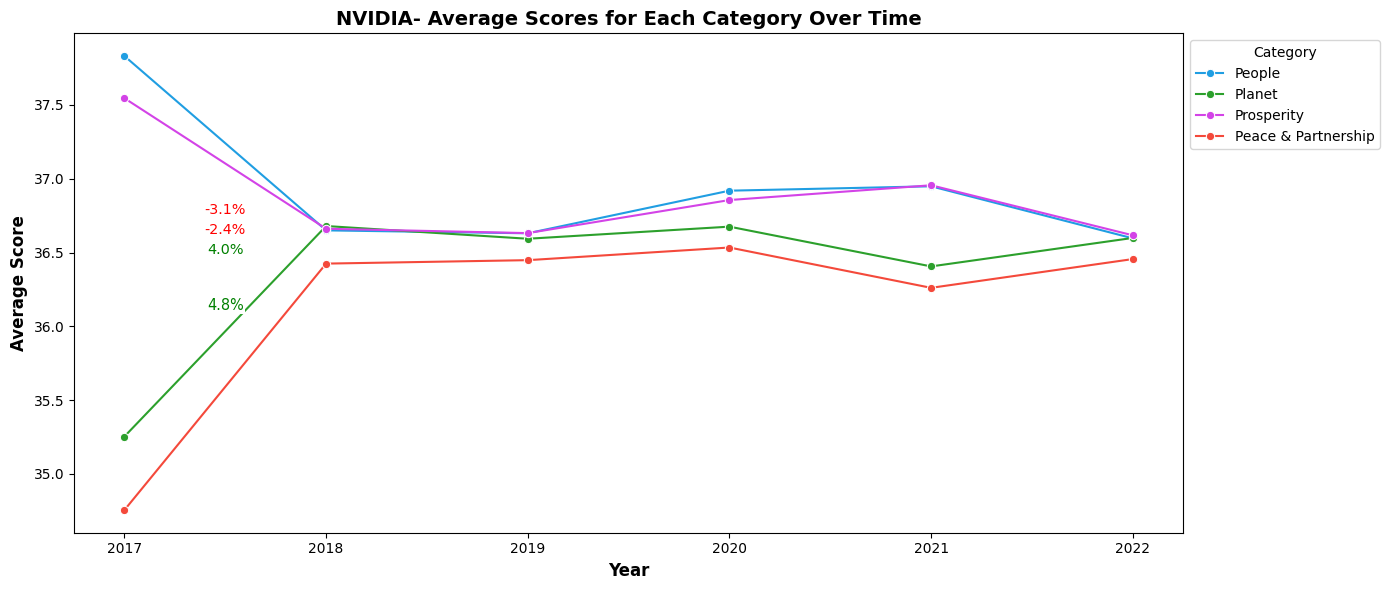

In [55]:
vis_5Ps(nvidia_5Ps,"NVIDIA")

# **GOOGLE**

##BDA,AI, ML Terms

In [56]:
google_bda_count = expl_bda_func(google_df)

In [57]:
google_bda_count

,year,mentions
0,2017,17
1,2018,9
2,2019,28
3,2020,39
4,2021,0
5,2022,93


In [58]:
google_bda_count=google_bda_count.rename(columns={'mentions':'google_bda_mentions'})

In [59]:
google_bda_sentences = google_df.copy()
google_bda_sentences['year'] = google_bda_sentences['fname'].str.split(r'_|\(|\-|\.').apply(lambda x: x[1])
google_bda_sentences = sentence_bda_bool_check(google_bda_sentences)


In [60]:
google_bda_sentences = google_bda_sentences[google_bda_sentences['contains_bda_term'] == True]

In [61]:
google_bda_sentences

,doc_id,fname,sentence,year,contains_bda_term
5,0,Google_2017.pdf,launched to give nonprofit groups the resource...,2017,True
44,0,Google_2017.pdf,our vision is to use our mapping cloud and mac...,2017,True
133,0,Google_2017.pdf,global fishing watch powered by google cloud p...,2017,True
197,0,Google_2017.pdf,finally we apply machine learning to drive ene...,2017,True
222,0,Google_2017.pdf,machine learning puts the oomph in many of goo...,2017,True
...,...,...,...,...,...
1007,5,Google_2022.pdf,google partnered with the australian governmen...,2022,True
1035,5,Google_2022.pdf,google is a partner of the ellen macarthur fou...,2022,True
1058,5,Google_2022.pdf,fao uses google earth engine for satellite rem...,2022,True
1259,5,Google_2022.pdf,38 transport improving the sustainability of p...,2022,True


##Topic Modelling

In [62]:
google_bert_top, probs = bert_model(google_bda_sentences)

In [63]:
google_bert_top.get_representative_docs(3)

['our vision is to use our mapping cloud and machine learning technologies to create a living breathing dashboard of our planet that can help inform everyday decisions for individuals organizations and nations today and for generations to come',
 'launched to give nonprofit groups the resources tools and inspiration they need in order to leverage the power of  earth and other mapping tools for their causes earth outreach is now combining machine learning and cloud computing to build a living breathing dashboard of the planet creating new insights both in local communities after years of reporting our carbon footprint and publishing information on our sustainability programs in december 2016 we put our whole story in one place in our first environmental report',
 'our vision is to leverage our mapping cloud and machine learning technologies to create a living breathing dashboard of our planet that can help inform everyday decisions for individuals organizations and nationstoday and for 

In [64]:
google_topic_df=google_bert_top.get_topic_info()

In [65]:
google_topic_df

,Topic,Count,Name,Representation,Representative_Docs
0,-1,42,-1_ai_decisionmaking_learning_knowledge,"[ai, decisionmaking, learning, knowledge, anal...",[applications of machine learning ml and ai ar...
1,0,38,0_energy_efficiency_deepmind_renewable,"[energy, efficiency, deepmind, renewable, elec...",[from 2011 to 2022 nest thermostats have helpe...
2,1,34,1_ai_initiatives_sustainability_projects,"[ai, initiatives, sustainability, projects, fu...",[by the end of 2018 waze carpool was available...
3,2,29,2_floods_flood_floodforecasting_forecasting,"[floods, flood, floodforecasting, forecasting,...",[beyond our operations s ai for social good pr...
4,3,12,3_cloud_datasets_analytics_planet,"[cloud, datasets, analytics, planet, dashboard...",[our vision is to use our mapping cloud and ma...


##Explicit SDG Mentions

In [66]:
google_sdg_count = expl_sdg_func(google_df)
google_sdg_count

,year,mentions
0,2017,0
1,2018,0
2,2019,0
3,2020,2
4,2021,0
5,2022,3


In [67]:
google_sdg_count=google_sdg_count.rename(columns={'mentions':'google_sdg_mentions'})

##Sentence Similarity with SDGs and 5Ps mapping

In [68]:
google_df = create_scorecard(google_df)

google_df, avg, std = add_scores(google_df)
google_df = rename_cols(google_df)

In [69]:
google_grouped = grouping(google_df)
google_grouped


Poverty     Hunger     Health  Education  Gender_Equality  \
company year                                                                
Google  2017  30.320256  32.764980  30.845630  28.499016        40.748996   
        2018  30.699125  33.203583  31.124708  28.704354        41.407604   
        2019  31.489330  33.849969  31.834657  29.396153        42.305903   
        2020  31.619779  33.907870  31.666611  29.345375        42.523455   
        2021  32.345043  34.993034  32.730726  30.412821        44.501923   
        2022  32.038389  34.402099  32.255743  29.738914        43.033939   

                  Water  Clean_Energy  Decent_Work  \
company year                                         
Google  2017  31.083622     24.936909    29.466909   
        2018  31.407625     24.997312    29.801396   
        2019  32.004159     25.701106    30.557196   
        2020  32.028907     25.727274    30.641810   
        2021  32.620598     25.804188    31.621838   
        2022  32.518995     26.149335    31.071146   

              Industry_Innovation_Infrastructure  Reduced_Inequalities  \
company year                                                             
Google  2017                           42.901693             29.551437   
        2018                           43.434083             29.796396   
        2019                           44.093567             30.466526   
        2020                           44.302737             30.487925   
        2021                           45.665726             31.110769   
        2022                           44.803740             30.812092   

              Sustainable_Cities_Communities  \
company year                                   
Google  2017                       39.334272   
        2018                       39.748125   
        2019                       40.571433   
        2020                       40.768355   
        2021                       42.398547   
        2022                       41.286430   

              Responsible_Consumption_Production  Climate_Action  \
company year                                                       
Google  2017                           40.702835       52.911969   
        2018                           41.093125       53.395937   
        2019                           41.704969       54.245857   
        2020                           42.166667       54.595563   
        2021                           44.182521       56.687137   
        2022                           42.501256       55.371530   

              Life_Below_Water  Life_on_Land  \
company year                                   
Google  2017         42.766752     42.298602   
        2018         43.146458     42.620354   
        2019         44.126449     43.392492   
        2020         44.433400     43.709426   
        2021         46.110684     45.631453   
        2022         44.979978     44.156038   

              Peace_Justice_and_Strong_Institutions  \
company year                                          
Google  2017                              43.738622   
        2018                              44.300062   
        2019                              45.082056   
        2020                              45.263631   
        2021                              47.373932   
        2022                              45.714043   

              Partnerships_for_the_Goals  
company year                              
Google  2017                   39.436909  
        2018                   39.792042  
        2019                   40.386246  
        2020                   40.520993  
        2021                   41.701581  
        2022                   40.852203

In [70]:
print("Min:",google_grouped.values.min())
print("Max:",google_grouped.values.max())

Min: 24.9369094488189
Max: 56.68713675213676


In [71]:
google_5Ps = map_5Ps(google_grouped)

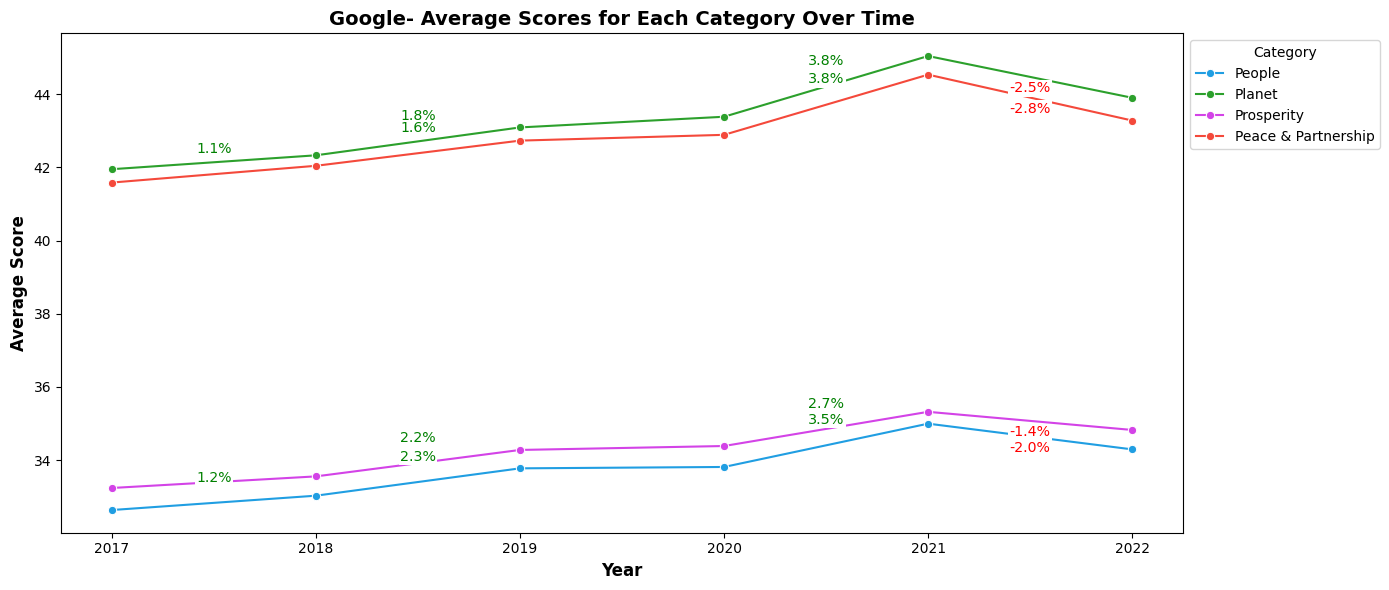

In [72]:
vis_5Ps(google_5Ps,"Google")

#**MICROSOFT**

##BDA,AI,ML Terms

In [73]:
microsoft_bda_count = expl_bda_func(microsoft_df)

In [74]:
microsoft_bda_count

,year,mentions
0,2017,20
1,2018,34
2,2019,46
3,2020,35
4,2021,87
5,2022,49


In [75]:
microsoft_bda_count.columns=['year','microsoft_bda_mentions']

In [76]:
microsoft_bda_count

,year,microsoft_bda_mentions
0,2017,20
1,2018,34
2,2019,46
3,2020,35
4,2021,87
5,2022,49


In [77]:
microsoft_bda_sentences = microsoft_df.copy()
microsoft_bda_sentences['year'] = microsoft_bda_sentences['fname'].str.split(r'_|\(|\-|\.').apply(lambda x: x[1])
microsoft_bda_sentences = sentence_bda_bool_check(microsoft_bda_sentences)


In [78]:
microsoft_bda_sentences = microsoft_bda_sentences[microsoft_bda_sentences['contains_bda_term'] == True]

##Topic Modelling

In [79]:
microsoft_bda_sentences

,doc_id,fname,sentence,year,contains_bda_term
75,0,Micro_2021.pdf,since its inception in 2017 our ai for earth p...,2021,True
180,0,Micro_2021.pdf,build a planetary computer we will aggregate e...,2021,True
182,0,Micro_2021.pdf,invested to protect more than 17000 acres of l...,2021,True
220,0,Micro_2021.pdf,we will help our suppliers customers and partn...,2021,True
287,0,Micro_2021.pdf,deploying ai to improve energy efficiency micr...,2021,True
...,...,...,...,...,...
113,5,Micro_2017.pdf,microsoft has both the capability and the cult...,2017,True
189,5,Micro_2017.pdf,weve issued a major update to our global human...,2017,True
335,5,Micro_2017.pdf,driving innovation we continue to push the lim...,2017,True
403,5,Micro_2017.pdf,through ai for earth were bringing together ai...,2017,True


In [80]:
# lda_topic, lda_vis = lda_model(nvidia_bda_sentences)

microsoft_bert_top, probs = bert_model(microsoft_bda_sentences)

# pyLDAvis.display(lda_vis)


In [81]:
microsoft_bert_top.get_representative_docs(0)

['we are dedicated to using our technology to help customers partners and suppliers around the world reduce their waste footprints through our learnings and with the power of data ai and digital technology',
 'we are working to help our customers partners and suppliers around the world to reduce their carbon footprints understand waterrelated risks and make environmental decisions through our learnings and with the power of data ai and digital technology',
 'we will help our suppliers customers and partners around the world to reduce their carbon footprints through our learnings and with the power of data ai and digital technology']

In [82]:
microsoft_topic_df=microsoft_bert_top.get_topic_info()

In [83]:
microsoft_topic_df

,Topic,Count,Name,Representation,Representative_Docs
0,-1,16,-1_ai_robots_beachbot_cloud,"[ai, robots, beachbot, cloud, roadmap, policy,...",[the policy roadmap is grounded in our belief ...
1,0,130,0_ai_technologies_data_technology,"[ai, technologies, data, technology, computing...",[we are dedicated to using our technology to h...
2,1,95,1_ai_humanitarian_disabilities_technology,"[ai, humanitarian, disabilities, technology, a...",[through our ai for good initiative we seek to...


##Explicit SDG Mentions

In [84]:
microsoft_sdg_count = expl_sdg_func(microsoft_df)
microsoft_sdg_count

,year,mentions
0,2017,19
1,2018,9
2,2019,2
3,2020,10
4,2021,1
5,2022,0


In [85]:
microsoft_sdg_count=microsoft_sdg_count.rename(columns={'mentions':'microsoft_sdg_mentions'})

##Sentence Similarity with SDGs and 5Ps mapping

In [86]:
microsoft_df = create_scorecard(microsoft_df)

microsoft_df, avg, std = add_scores(microsoft_df)
microsoft_df = rename_cols(microsoft_df)

In [87]:
microsoft_grouped = grouping(microsoft_df)
microsoft_grouped

Poverty     Hunger     Health  Education  Gender_Equality  \
company year                                                                
Micro   2017  38.310108  40.542602  37.437269  34.894022        51.017118   
        2018  37.614879  40.386450  36.462054  33.912734        49.915015   
        2019  39.373768  41.654731  38.533626  35.786232        52.095609   
        2020  38.445175  40.649520  37.556135  35.044476        51.217162   
        2021  36.566110  39.345737  35.749637  32.018242        46.257848   
        2022  37.552629  40.243063  36.403230  32.732071        48.480681   

                  Water  Clean_Energy  Decent_Work  \
company year                                         
Micro   2017  38.331505     30.394710    37.559806   
        2018  37.096798     29.540937    36.762341   
        2019  39.693456     31.504164    38.577904   
        2020  38.497031     30.499629    37.713035   
        2021  35.203683     29.342422    35.386976   
        2022  36.088371     29.093367    36.089710   

              Industry_Innovation_Infrastructure  Reduced_Inequalities  \
company year                                                             
Micro   2017                           51.256409             36.819785   
        2018                           49.758701             35.845816   
        2019                           52.175666             37.996459   
        2020                           51.433799             36.967686   
        2021                           47.029839             35.542998   
        2022                           48.987813             35.728132   

              Sustainable_Cities_Communities  \
company year                                   
Micro   2017                       49.424624   
        2018                       48.501752   
        2019                       51.009745   
        2020                       49.636092   
        2021                       47.747739   
        2022                       49.343592   

              Responsible_Consumption_Production  Climate_Action  \
company year                                                       
Micro   2017                           49.555828       62.206774   
        2018                           48.330453       60.614335   
        2019                           50.839943       62.432890   
        2020                           49.718188       62.321048   
        2021                           48.783859       54.132407   
        2022                           51.326155       56.632303   

              Life_Below_Water  Life_on_Land  \
company year                                   
Micro   2017         53.941914     52.540774   
        2018         53.108807     51.664698   
        2019         54.757790     53.367252   
        2020         54.066747     52.690961   
        2021         51.189051     50.003413   
        2022         53.157024     51.606959   

              Peace_Justice_and_Strong_Institutions  \
company year                                          
Micro   2017                              56.000860   
        2018                              55.709396   
        2019                              57.019235   
        2020                              56.179127   
        2021                              52.736976   
        2022                              54.428740   

              Partnerships_for_the_Goals  
company year                              
Micro   2017                   49.763634  
        2018                   49.571601  
        2019                   50.928782  
        2020                   49.924716  
        2021                   48.827925  
        2022                   50.239768

In [88]:
print("Min:",microsoft_grouped.values.min())
print("Max:",microsoft_grouped.values.max())

Min: 29.093367125271545
Max: 62.4328895184136


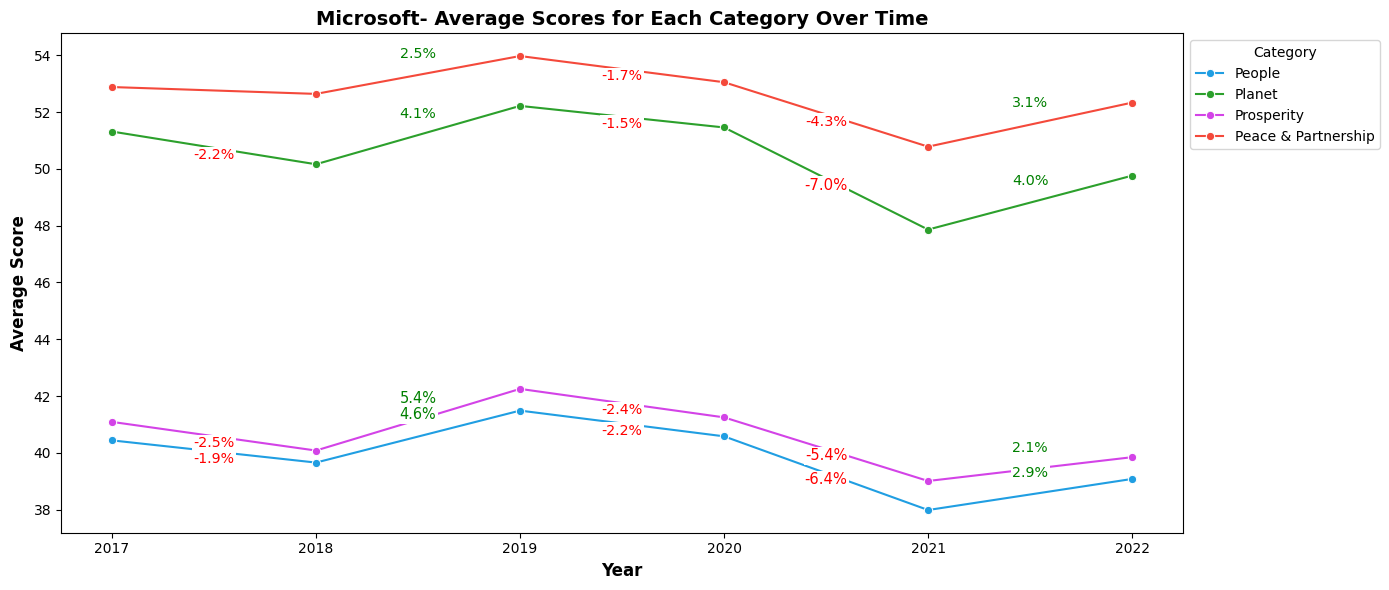

In [89]:
microsoft_5Ps = map_5Ps(microsoft_grouped)
vis_5Ps(microsoft_5Ps,"Microsoft")

#**SAMSUNG**

##BDA,AI, ML Terms

In [90]:
samsung_bda_count = expl_bda_func(samsung_df)

In [91]:
samsung_bda_count

,year,mentions
0,2017,9
1,2018,3
2,2019,29
3,2020,46
4,2021,47
5,2022,45


In [92]:
samsung_bda_count=samsung_bda_count.rename(columns={'mentions':'samsung_bda_mentions'})

In [93]:
samsung_bda_sentences = samsung_df.copy()
samsung_bda_sentences['year'] = samsung_bda_sentences['fname'].str.split(r'_|\(|\-|\.').apply(lambda x: x[1])
samsung_bda_sentences = sentence_bda_bool_check(samsung_bda_sentences)

In [94]:
samsung_bda_sentences = samsung_bda_sentences[samsung_bda_sentences['contains_bda_term'] == True]

In [95]:
samsung_bda_sentences

,doc_id,fname,sentence,year,contains_bda_term
8,0,Sam_2017.pdf,indeed we will relentlessly push for ward our ...,2017,True
81,0,Sam_2017.pdf,furthermore our investment and rd will continu...,2017,True
169,0,Sam_2017.pdf,weekly decisionmaking quick supply response ...,2017,True
236,0,Sam_2017.pdf,as such we plan to invest strategically and de...,2017,True
407,0,Sam_2017.pdf,we deeply understand that the generation of ec...,2017,True
...,...,...,...,...,...
970,5,Sam_2022.pdf,ai ethics is not mathematics and there is no s...,2022,True
971,5,Sam_2022.pdf,we must remain alert and strive to find ways t...,2022,True
987,5,Sam_2022.pdf,selected as a winner in the accessibility ca...,2022,True
1683,5,Sam_2022.pdf,joining the united nations global compact p...,2022,True


##Topic Modeling

In [96]:
# lda_topic, lda_vis = lda_model(nvidia_bda_sentences)

samsung_bert_top, probs = bert_model(samsung_bda_sentences)

# pyLDAvis.display(lda_vis)


In [97]:
samsung_topic_df=samsung_bert_top.get_topic_info()

In [98]:
samsung_bert_top.get_representative_docs(1)

['students learn a variety of soft and practical skills starting with basic programming and developing mobile apps to ai and iot',
 ' innovation campus provides classroom education as well as handson training in skills that technologyrelated job positions require such as ai iot and data analysis',
 'trainees can strengthen basic software skills such as algorithms coding programming languages and databases and develop their software skills by using technologies such as ai and iot as part of an advanced curriculum']

In [99]:
samsung_topic_df

,Topic,Count,Name,Representation,Representative_Docs
0,0,141,0_accessibility_ai_ethics_ethical,"[accessibility, ai, ethics, ethical, sustainab...",[the training program deals with the latest gl...
1,1,18,1_iot_technologies_programming_competencies,"[iot, technologies, programming, competencies,...",[students learn a variety of soft and practica...


## Explicit SDG Mentions

In [100]:
samsung_sdg_count = expl_sdg_func(samsung_df)
samsung_sdg_count

,year,mentions
0,2017,54
1,2018,85
2,2019,36
3,2020,23
4,2021,25
5,2022,17


In [101]:
samsung_sdg_count=samsung_sdg_count.rename(columns={'mentions':'samsung_sdg_mentions'})

##Sentence Similarity and 5Ps mapping

In [102]:
samsung_df = create_scorecard(samsung_df)

samsung_df, avg, std = add_scores(samsung_df)
samsung_df = rename_cols(samsung_df)

samsung_grouped = grouping(samsung_df)

In [103]:
samsung_grouped

Poverty     Hunger     Health  Education  Gender_Equality  \
company year                                                                
Sam     2017  43.354831  43.992442  42.544982  40.996907        51.618164   
        2018  42.379804  42.759300  41.410203  40.092330        50.918006   
        2019  42.468101  42.871096  41.427927  40.158798        51.184695   
        2020  42.369533  42.720307  41.378976  40.082300        50.908976   
        2021  42.514050  42.807202  41.372195  40.295366        51.190109   
        2022  42.633634  43.165175  41.854979  40.177853        51.192370   

                  Water  Clean_Energy  Decent_Work  \
company year                                         
Sam     2017  45.658868     40.185152    44.629020   
        2018  44.562281     38.767614    43.339370   
        2019  44.494994     38.425243    43.286065   
        2020  44.563568     38.746397    43.323394   
        2021  44.613537     38.557253    43.401675   
        2022  44.609145     38.651126    43.313151   

              Industry_Innovation_Infrastructure  Reduced_Inequalities  \
company year                                                             
Sam     2017                           46.602594             44.936168   
        2018                           46.005745             43.564003   
        2019                           46.084134             43.275915   
        2020                           46.013108             43.539840   
        2021                           45.952606             43.339056   
        2022                           46.690919             43.336164   

              Sustainable_Cities_Communities  \
company year                                   
Sam     2017                       46.751613   
        2018                       45.708824   
        2019                       45.794956   
        2020                       45.677143   
        2021                       45.661431   
        2022                       46.482333   

              Responsible_Consumption_Production  Climate_Action  \
company year                                                       
Sam     2017                           40.277282       48.101676   
        2018                           39.427656       47.805150   
        2019                           39.626930       48.128792   
        2020                           39.398216       47.766592   
        2021                           39.351598       47.874531   
        2022                           41.122418       49.282970   

              Life_Below_Water  Life_on_Land  \
company year                                   
Sam     2017         47.289742     43.128119   
        2018         46.119272     42.182281   
        2019         46.419371     42.368499   
        2020         46.064976     42.139575   
        2021         46.075103     42.069422   
        2022         47.447264     43.632588   

              Peace_Justice_and_Strong_Institutions  \
company year                                          
Sam     2017                              44.740214   
        2018                              43.930658   
        2019                              44.008076   
        2020                              43.896815   
        2021                              43.793659   
        2022                              45.077455   

              Partnerships_for_the_Goals  
company year                              
Sam     2017                   41.762175  
        2018                   40.923961  
        2019                   41.140118  
        2020                   40.894307  
        2021                   40.852689  
        2022                   42.182949

In [104]:
print("Min:",samsung_grouped.values.min())
print("Max:",samsung_grouped.values.max())

Min: 38.42524283935243
Max: 51.618163992869874


In [105]:
samsung_5Ps = map_5Ps(samsung_grouped)

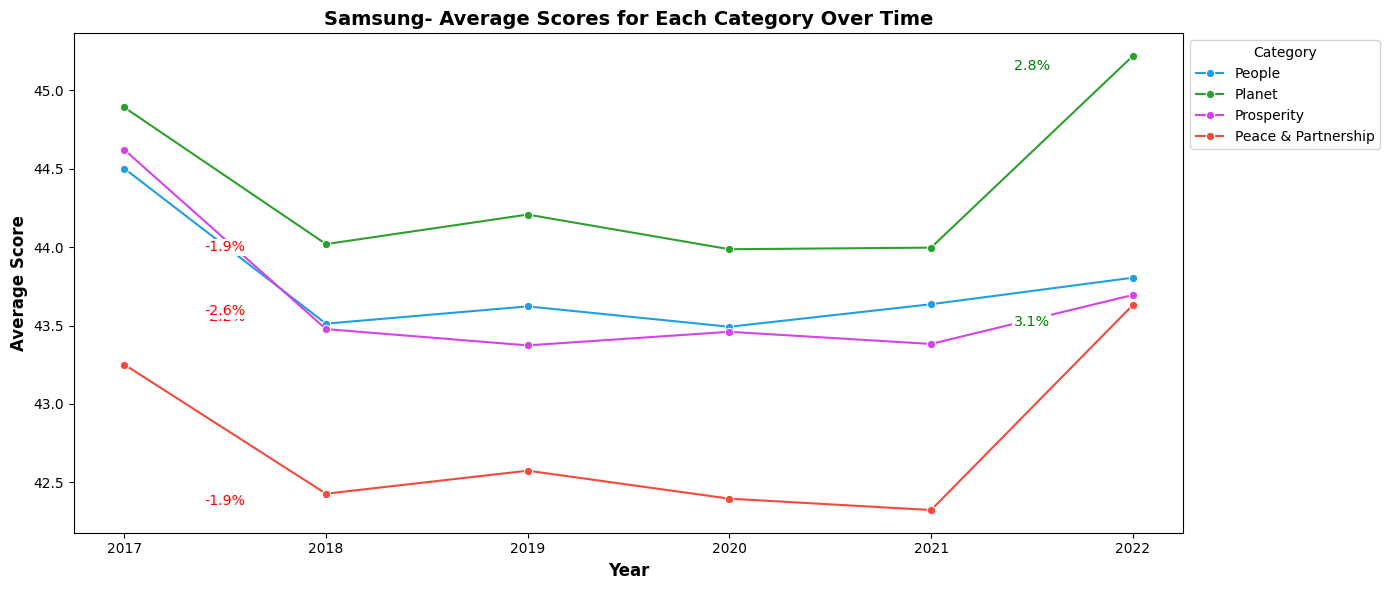

In [106]:
vis_5Ps(samsung_5Ps,"Samsung")

#**TSMC**

##BDA,AI,ML Terms

In [107]:
tsmc_bda_count = expl_bda_func(tsmc_df)

In [108]:
tsmc_bda_count

,year,mentions
0,2017,23
1,2018,21
2,2019,24
3,2020,50
4,2021,35
5,2022,40


In [109]:
tsmc_bda_count=tsmc_bda_count.rename(columns={'mentions':'tsmc_bda_mentions'})

In [110]:
tsmc_bda_sentences = tsmc_df.copy()
tsmc_bda_sentences['year'] = tsmc_bda_sentences['fname'].str.split(r'_|\(|\-|\.').apply(lambda x: x[1])
tsmc_bda_sentences = sentence_bda_bool_check(tsmc_bda_sentences)


In [111]:
tsmc_bda_sentences = tsmc_bda_sentences[tsmc_bda_sentences['contains_bda_term'] == True]

##Topic Modeling

In [112]:
tsmc_bda_sentences

,doc_id,fname,sentence,year,contains_bda_term
31,0,TSMC_2017.pdf,newsweek selected by newsweek green rankings a...,2017,True
345,0,TSMC_2017.pdf,the trade secrets included not only those rela...,2017,True
350,0,TSMC_2017.pdf,machine learning and deep learning are thoroug...,2017,True
351,0,TSMC_2017.pdf,machine learning is the essence for intelligen...,2017,True
352,0,TSMC_2017.pdf,to speed up machine learning applications and ...,2017,True
...,...,...,...,...,...
1410,5,TSMC_2021.pdf,the ai hazard analysis technology uses existin...,2021,True
1595,5,TSMC_2021.pdf,enforce audits to ensure safe construction sit...,2021,True
1604,5,TSMC_2021.pdf,environmental temperature monitoring to preven...,2021,True
1795,5,TSMC_2021.pdf,the tsmc charity foundation has also worked wi...,2021,True


In [113]:

tsmc_bert_top, probs = bert_model(tsmc_bda_sentences)

In [114]:
tsmc_topic_df=tsmc_bert_top.get_topic_info()

In [115]:
tsmc_bert_top.get_representative_docs(1)

['specialty technologies interconnect and packaging technologies received cowos s certication for gen3 hbm silicon interposer now contains submicron routing layers and integrated capacitors icap so that various chiplets such as soc hbm can be placed on it successfully qualied infopop gen8 for mobile applications with enhanced thermal performance launched rd for next generation info pop which will introduce backside redistribution layer successfully qualied infoos gen4 which provides more chip partition integration with larger package size and higher bandwidth optimized quality factors of 5v components on 55nm bcd targeting power switches for portable devices continued to expand 40nm 22nm and 013 micron bdc technologies to meet automotive market demands 28nm eflash entered volume production  which can support mobile hpc and highperformance lowleakage platforms successfully riskproduced the worlds smallest voltage domain global shutter cmos image sensor chip with 3wafer stack technology 

In [116]:
tsmc_topic_df

,Topic,Count,Name,Representation,Representative_Docs
0,-1,15,-1_zeolite_concentrators_concentrator_cleangas...,"[zeolite, concentrators, concentrator, cleanga...",[zeolite rotor concentrators milestones increa...
1,0,98,0_manufacturing_technologies_technology_ai,"[manufacturing, technologies, technology, ai, ...",[promote continuous improvement programs to en...
2,1,35,1_cmos_iot_sensors_electronics,"[cmos, iot, sensors, electronics, chip, rram, ...",[specialty technologies interconnect and packa...


##Explicit SDG Mentions

In [117]:
tsmc_sdg_count = expl_sdg_func(tsmc_df)
tsmc_sdg_count

,year,mentions
0,2017,71
1,2018,68
2,2019,45
3,2020,43
4,2021,62
5,2022,74


In [118]:
tsmc_sdg_count=tsmc_sdg_count.rename(columns={'mentions':'tsmc_sdg_mentions'})

##Sentence Similarity and 5Ps mapping

In [119]:
tsmc_df = create_scorecard(tsmc_df)

tsmc_df, avg, std = add_scores(tsmc_df)
tsmc_df = rename_cols(tsmc_df)

In [120]:
tsmc_grouped = grouping(tsmc_df)
tsmc_grouped

Poverty     Hunger     Health  Education  Gender_Equality  \
company year                                                                
TSMC    2017  38.464390  39.440749  39.542334  37.226521        48.007091   
        2018  39.039872  40.328844  39.789041  37.543682        49.046345   
        2019  39.048852  40.092930  39.752122  37.484042        48.772554   
        2020  38.613542  40.117560  39.504145  37.206050        48.893503   
        2021  39.150977  40.345093  39.891228  37.584833        49.067953   
        2022  39.085007  40.338064  39.827853  37.548860        49.075356   

                  Water  Clean_Energy  Decent_Work  \
company year                                         
TSMC    2017  42.334396     35.867538    39.356220   
        2018  42.756117     36.490735    40.322485   
        2019  42.727595     36.371946    40.076756   
        2020  42.292088     35.948168    39.819953   
        2021  42.876740     36.576423    40.378912   
        2022  42.814441     36.522349    40.345002   

              Industry_Innovation_Infrastructure  Reduced_Inequalities  \
company year                                                             
TSMC    2017                           43.798084             39.108961   
        2018                           44.452545             40.299173   
        2019                           44.507868             39.893831   
        2020                           44.144583             39.746110   
        2021                           44.626912             40.355274   
        2022                           44.528487             40.318092   

              Sustainable_Cities_Communities  \
company year                                   
TSMC    2017                       43.503618   
        2018                       44.148022   
        2019                       44.106426   
        2020                       43.872062   
        2021                       44.243898   
        2022                       44.203802   

              Responsible_Consumption_Production  Climate_Action  \
company year                                                       
TSMC    2017                           40.024065       45.989733   
        2018                           39.459274       46.406916   
        2019                           39.841004       46.553023   
        2020                           39.364575       46.418584   
        2021                           39.660874       46.547400   
        2022                           39.532772       46.465917   

              Life_Below_Water  Life_on_Land  \
company year                                   
TSMC    2017         45.684262     42.179187   
        2018         46.287894     42.504756   
        2019         46.280541     42.540551   
        2020         46.177062     42.396288   
        2021         46.417437     42.653251   
        2022         46.337926     42.561903   

              Peace_Justice_and_Strong_Institutions  \
company year                                          
TSMC    2017                              41.883571   
        2018                              42.594358   
        2019                              42.564490   
        2020                              42.336352   
        2021                              42.743530   
        2022                              42.658198   

              Partnerships_for_the_Goals  
company year                              
TSMC    2017                   38.116847  
        2018                   38.296862  
        2019                   38.419892  
        2020                   38.047372  
        2021                   38.444674  
        2022                   38.369389

In [121]:
print("Min:",tsmc_grouped.values.min())
print("Max:",tsmc_grouped.values.max())

Min: 35.86753774680604
Max: 49.07535632183908


In [122]:
tsmc_5Ps = map_5Ps(tsmc_grouped)

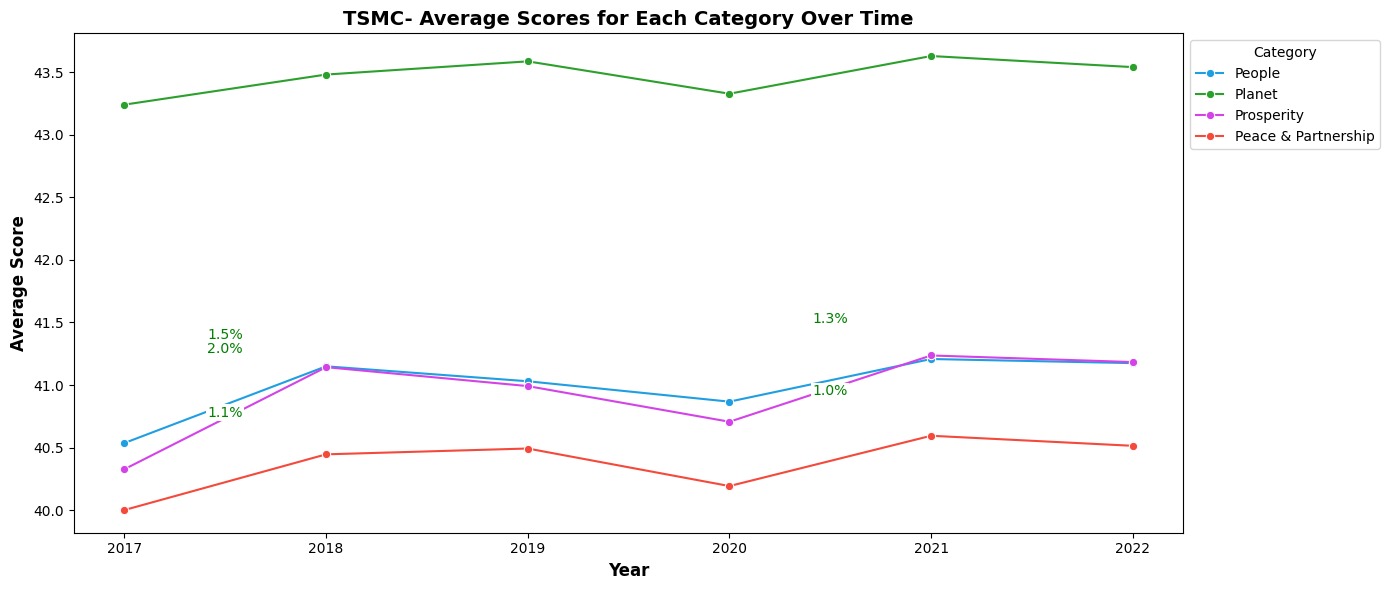

In [123]:
vis_5Ps(tsmc_5Ps,"TSMC")

#**Visualisations- 2**

# SDG Mentions and BDA Mentions Plots

In [124]:
#Plot SDG and BDA frequency measures on a single plot
high_perf_bda_counts=nvidia_bda_count.merge(microsoft_bda_count.merge(samsung_bda_count.merge(tsmc_bda_count.merge(google_bda_count,on='year'),on='year'),on='year'),on='year')
high_perf_sdg_counts=nvidia_sdg_count.merge(microsoft_sdg_count.merge(samsung_sdg_count.merge(tsmc_sdg_count.merge(google_sdg_count,on='year'),on='year'),on='year'),on='year')

In [125]:
high_perf_bda_counts

,year,nvidia_bda_mentions,microsoft_bda_mentions,samsung_bda_mentions,tsmc_bda_mentions,google_bda_mentions
0,2017,43,20,9,23,17
1,2018,68,34,3,21,9
2,2019,86,46,29,24,28
3,2020,90,35,46,50,39
4,2021,100,87,47,35,0
5,2022,121,49,45,40,93


In [126]:
high_perf_sdg_counts

,year,nvidia_sdg_mentions,microsoft_sdg_mentions,samsung_sdg_mentions,tsmc_sdg_mentions,google_sdg_mentions
0,2017,4,19,54,71,0
1,2018,16,9,85,68,0
2,2019,2,2,36,45,0
3,2020,2,10,23,43,2
4,2021,9,1,25,62,0
5,2022,7,0,17,74,3


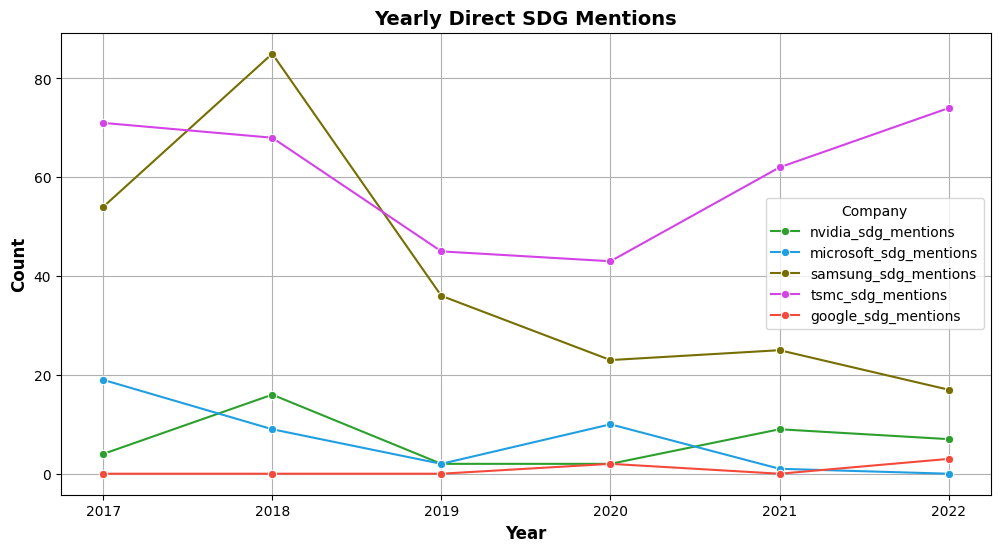

In [127]:
df_long = pd.melt(high_perf_sdg_counts, id_vars=['year'],
                  value_vars=['nvidia_sdg_mentions','microsoft_sdg_mentions', 'samsung_sdg_mentions', 'tsmc_sdg_mentions','google_sdg_mentions'],
                  var_name='Company', value_name='Mentions')


palette =['#2ca02c','#209EE2','#766E00','#D343E7','#F4493B']
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_long, x='year', y='Mentions', hue='Company', marker='o', linewidth=1.5,palette=palette)

plt.title('Yearly Direct SDG Mentions', fontweight='bold', fontsize=14)
plt.xlabel('Year', fontweight='bold', fontsize=12)
plt.ylabel('Count', fontweight='bold', fontsize=12)

plt.grid(True)
plt.legend(title='Company')
plt.show()

#Overall goals and companies Visualisation

In [128]:
def ungroup(df):
  df=df.reset_index()
  return df

In [129]:
nvidia_reset=ungroup(nvidia_grouped)
google_reset=ungroup(google_grouped)
microsoft_reset=ungroup(microsoft_grouped)
samsung_reset=ungroup(samsung_grouped)
tsmc_reset=ungroup(tsmc_grouped)

In [130]:
overall_comp_list=[nvidia_reset,google_reset,microsoft_reset,samsung_reset,tsmc_reset]
overall_sdg_df=pd.concat(overall_comp_list)

In [131]:
#Visualize SDG-wise cosine scores for all companies split into 2017-19 and 2020-22

def vis_all_comps_annot(df,yr):
  categories = df.columns[2:]
  years = df['year'].unique()
  df_melted=df.melt(id_vars=['company', 'year'], value_vars=categories, var_name='Category', value_name='Score')
  if yr==1:
    markers = ['o', 'X', '^']
    years="2017-2019"
  else:
    markers=['s','D','P']
    years="2020-2022"

  sns.set_style("whitegrid")
  palette =['#2ca02c','#F4493B','#209EE2','#766E00','#D343E7']
  plt.figure(figsize=(14, 8))
  ax=sns.lineplot(data=df_melted, x='Category', y='Score', hue='company', style='year', markers=True, dashes=True,palette=palette)

  plt.title('SDG Scores Over Time & Goals '+ years, fontsize=16, fontweight='bold')
  plt.xlabel('SDG Categories', fontsize=12, fontweight='bold')
  plt.ylabel('Scores', fontsize=12, fontweight='bold')
  plt.xticks(rotation=45, ha='right', fontsize=10)
  plt.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1, 1), ncol=1)

  plt.ylim(0, 70)
  plt.yticks(np.arange(0, 60, 10))

  ax.axhspan(0, 20, facecolor='red', alpha=0.1)
  ax.axhspan(50, 70, facecolor='green', alpha=0.1)


  avg_scores = df_melted.groupby('Category')['Score'].mean()


  top_5_high = avg_scores.nlargest(5).index
  top_5_low = avg_scores.nsmallest(5).index


  for category in top_5_high:
      max_score = df_melted[df_melted['Category'] == category]['Score'].max()
      ax.text(category, max_score + 2, 'High', color='green', ha='center', fontweight='bold')


  for category in top_5_low:
      min_score = df_melted[df_melted['Category'] == category]['Score'].min()
      ax.text(category, min_score - 2, 'Low', color='red', ha='center', fontweight='bold')

  plt.tight_layout()
  plt.show()





In [132]:

def vis_all_comps_sep_annot(df,pal,firm):
    categories = df.columns[2:]

    years = df['year'].unique()
    df_melted=df.melt(id_vars=['company', 'year'], value_vars=categories, var_name='Category', value_name='Score')

    markers = ['o', 'X', '^','s','D','P']
    years="2017-2022"

    sns.set_style("whitegrid")
    plt.figure(figsize=(14, 8))
    ax=sns.lineplot(data=df_melted, x='Category', y='Score', hue='company', style='year', markers=True, dashes=True,palette=pal)


    plt.title('SDG Scores Over Time & Goals- '+firm +' '+years, fontsize=16, fontweight='bold')
    plt.xlabel('SDG Categories', fontsize=12, fontweight='bold')
    plt.ylabel('Scores', fontsize=12, fontweight='bold')
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1, 1), ncol=1)

    plt.ylim(0, 70)
    plt.yticks(np.arange(0, 60, 10))


    ax.axhspan(0, 20, facecolor='red', alpha=0.1)
    ax.axhspan(50, 70, facecolor='green', alpha=0.1)


    avg_scores = df_melted.groupby('Category')['Score'].mean()


    top_5_high = avg_scores.nlargest(5).index
    top_5_low = avg_scores.nsmallest(5).index


    for category in top_5_high:
        max_score = df_melted[df_melted['Category'] == category]['Score'].max()
        ax.text(category, max_score + 2, 'High', color='green', ha='center', fontweight='bold')


    for category in top_5_low:
        min_score = df_melted[df_melted['Category'] == category]['Score'].min()
        ax.text(category, min_score - 2, 'Low', color='red', ha='center', fontweight='bold')

    plt.tight_layout()
    plt.show()


In [133]:
overall_sdg_df_2017_19=overall_sdg_df[overall_sdg_df['year'].isin(['2017','2018','2019'])]
overall_sdg_df_2020_22=overall_sdg_df[overall_sdg_df['year'].isin(['2020','2021','2022'])]

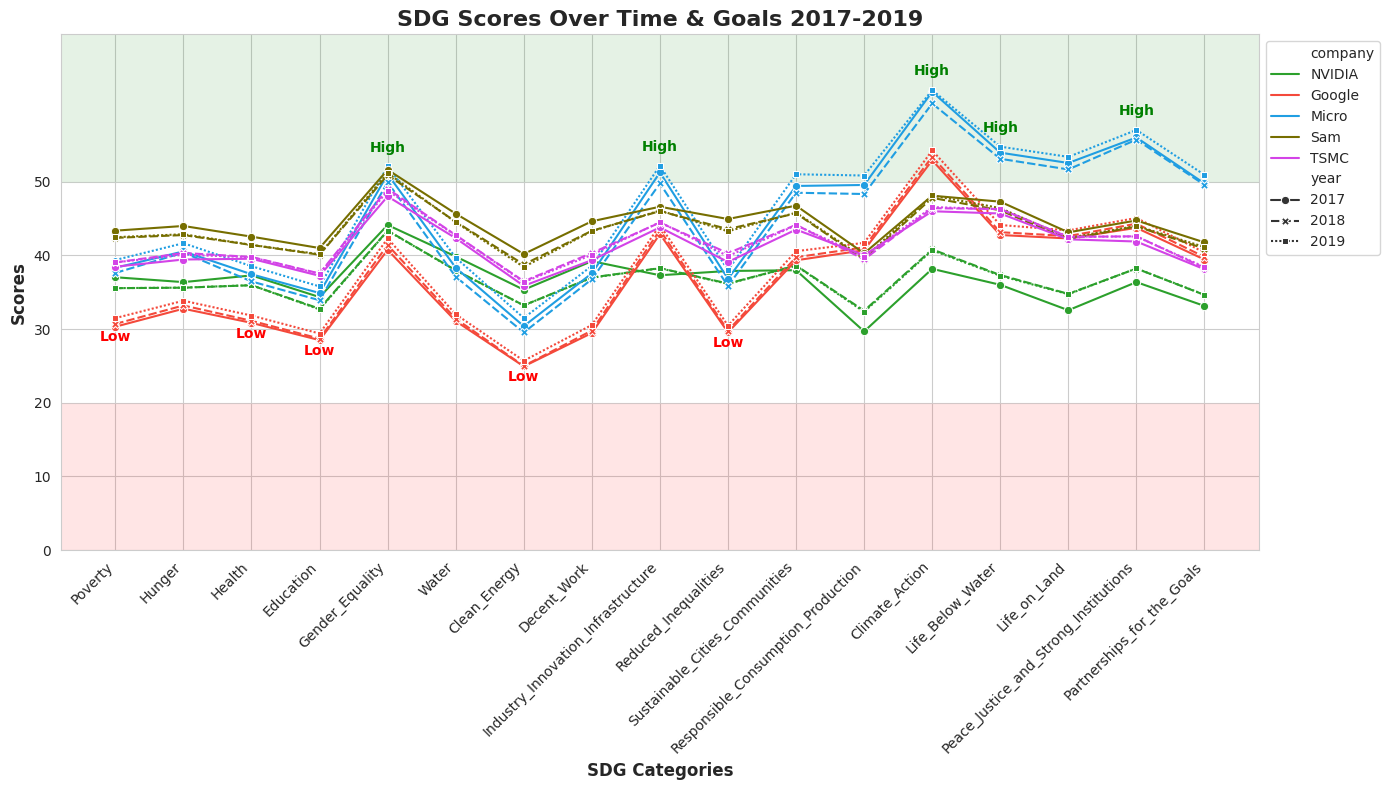

In [134]:
vis_all_comps_annot(overall_sdg_df_2017_19,1)

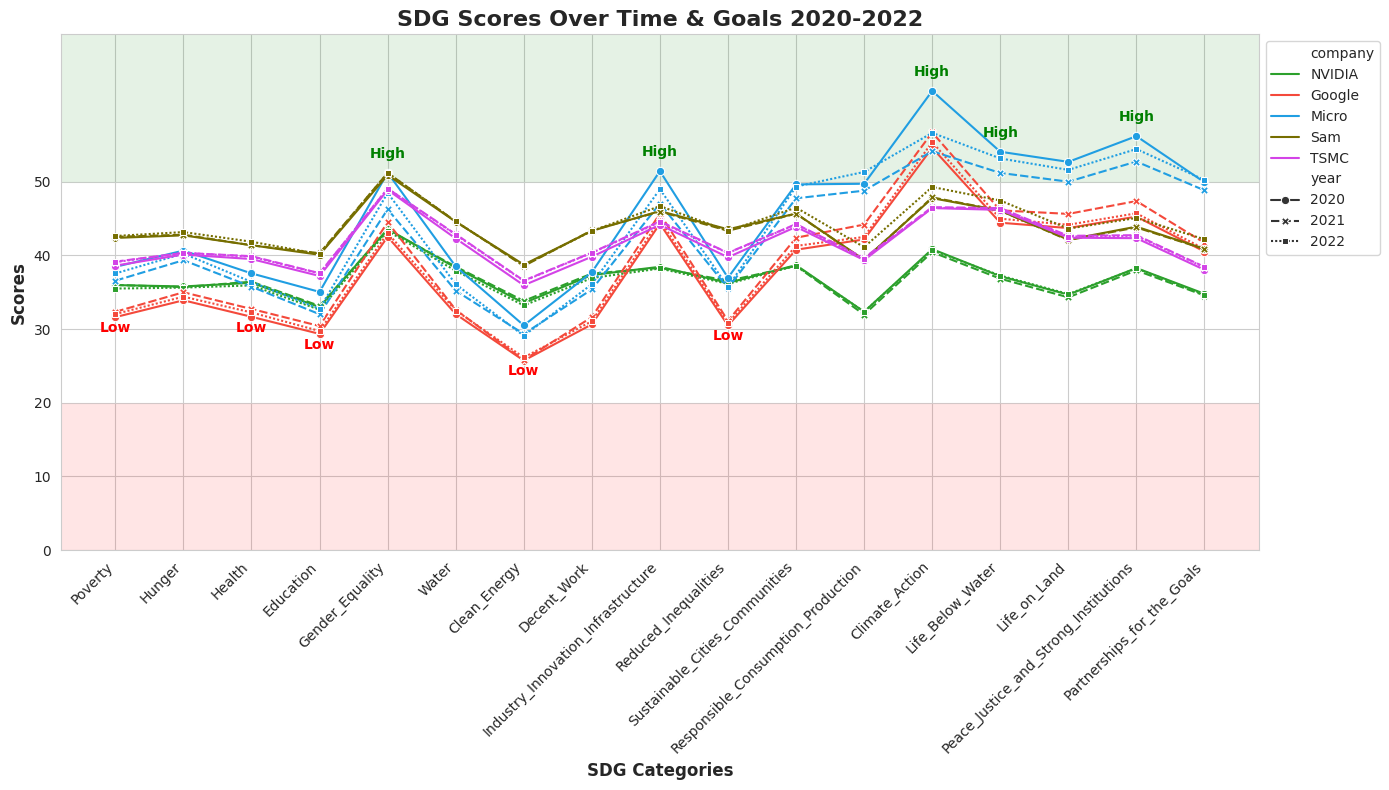

In [135]:
vis_all_comps_annot(overall_sdg_df_2020_22,2)

In [136]:
sam_tsmc_df=overall_sdg_df[overall_sdg_df['company'].isin(['Sam','TSMC'])]

In [137]:
other_df=overall_sdg_df[~overall_sdg_df['company'].isin(['Sam','TSMC'])]

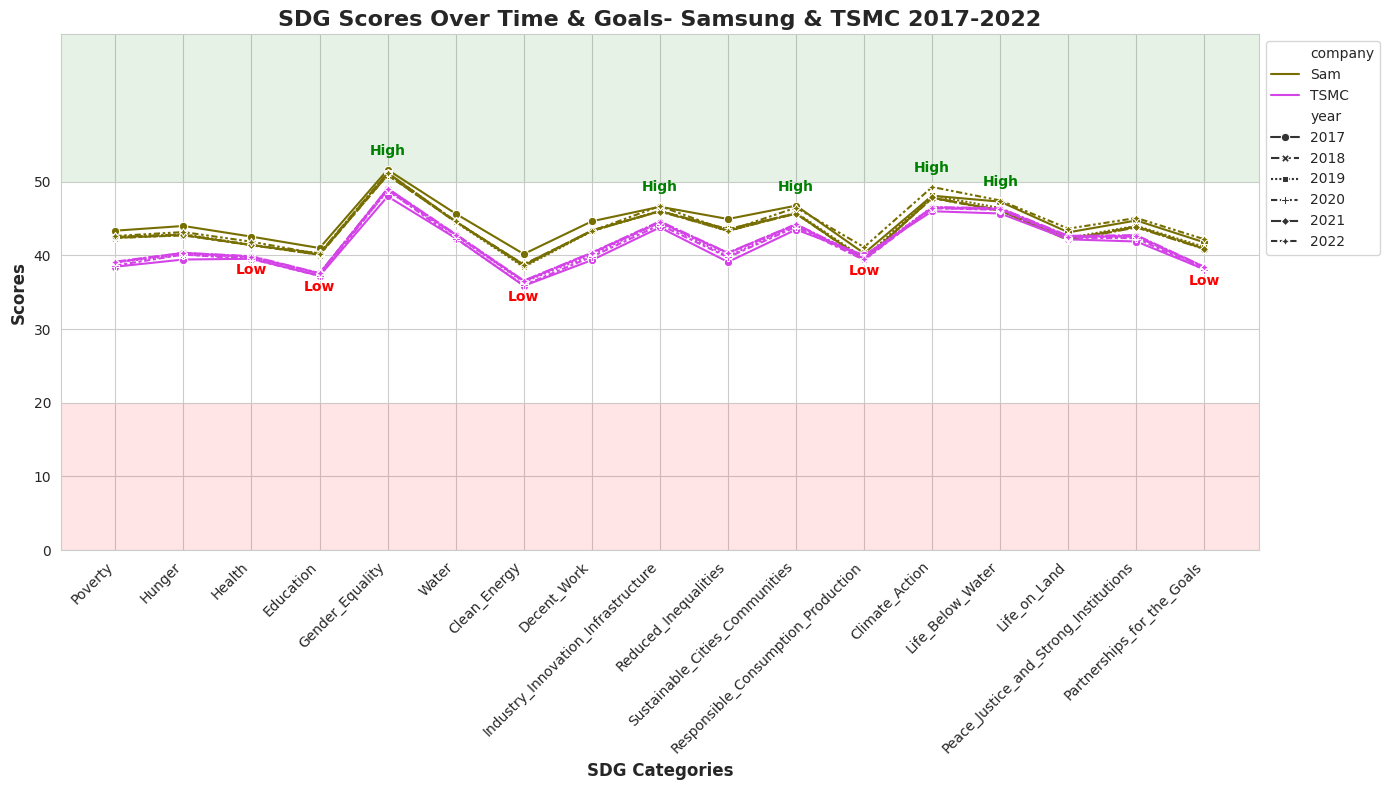

In [138]:
vis_all_comps_sep_annot(sam_tsmc_df,['#766E00', '#D343E7'],'Samsung & TSMC')

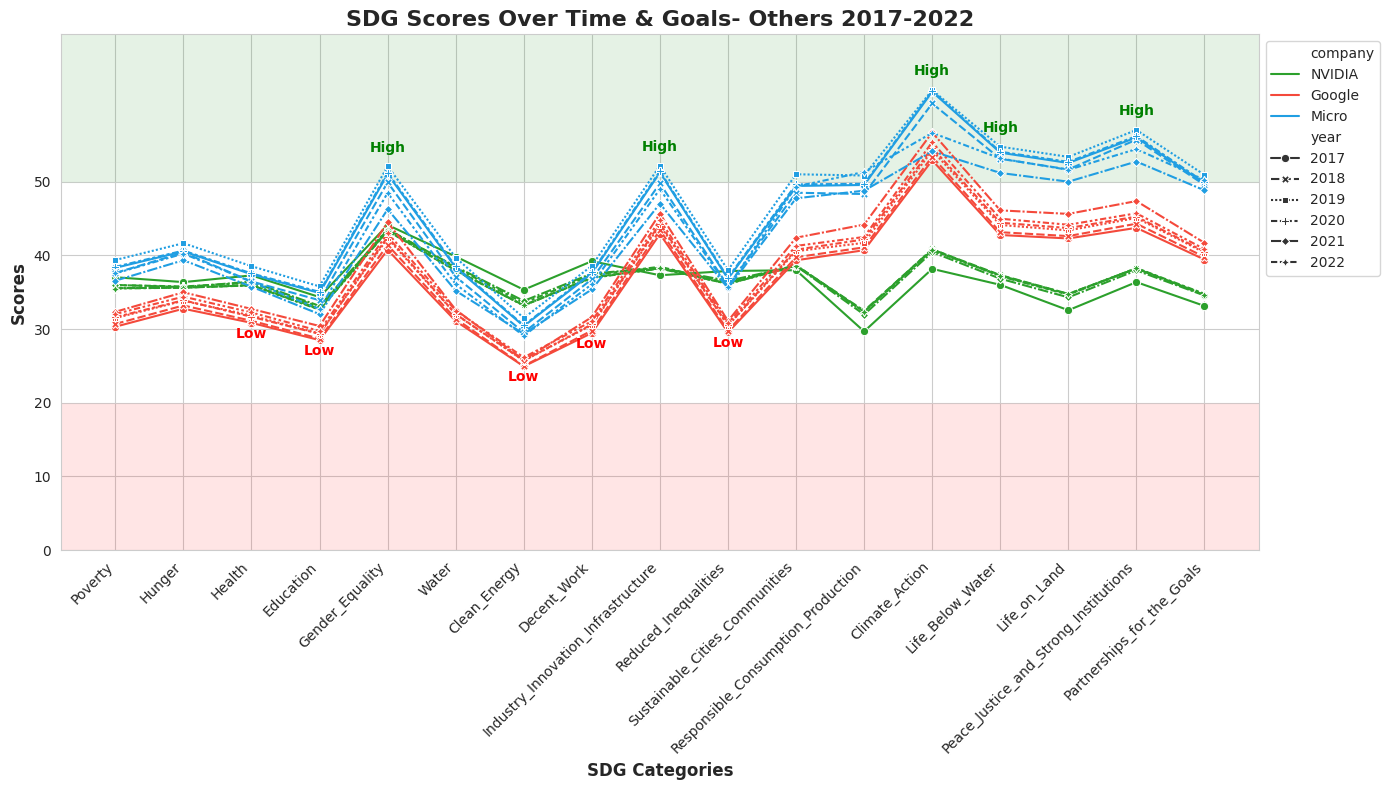

In [139]:
vis_all_comps_sep_annot(other_df,['#2ca02c','#F4493B','#209EE2'],'Others')

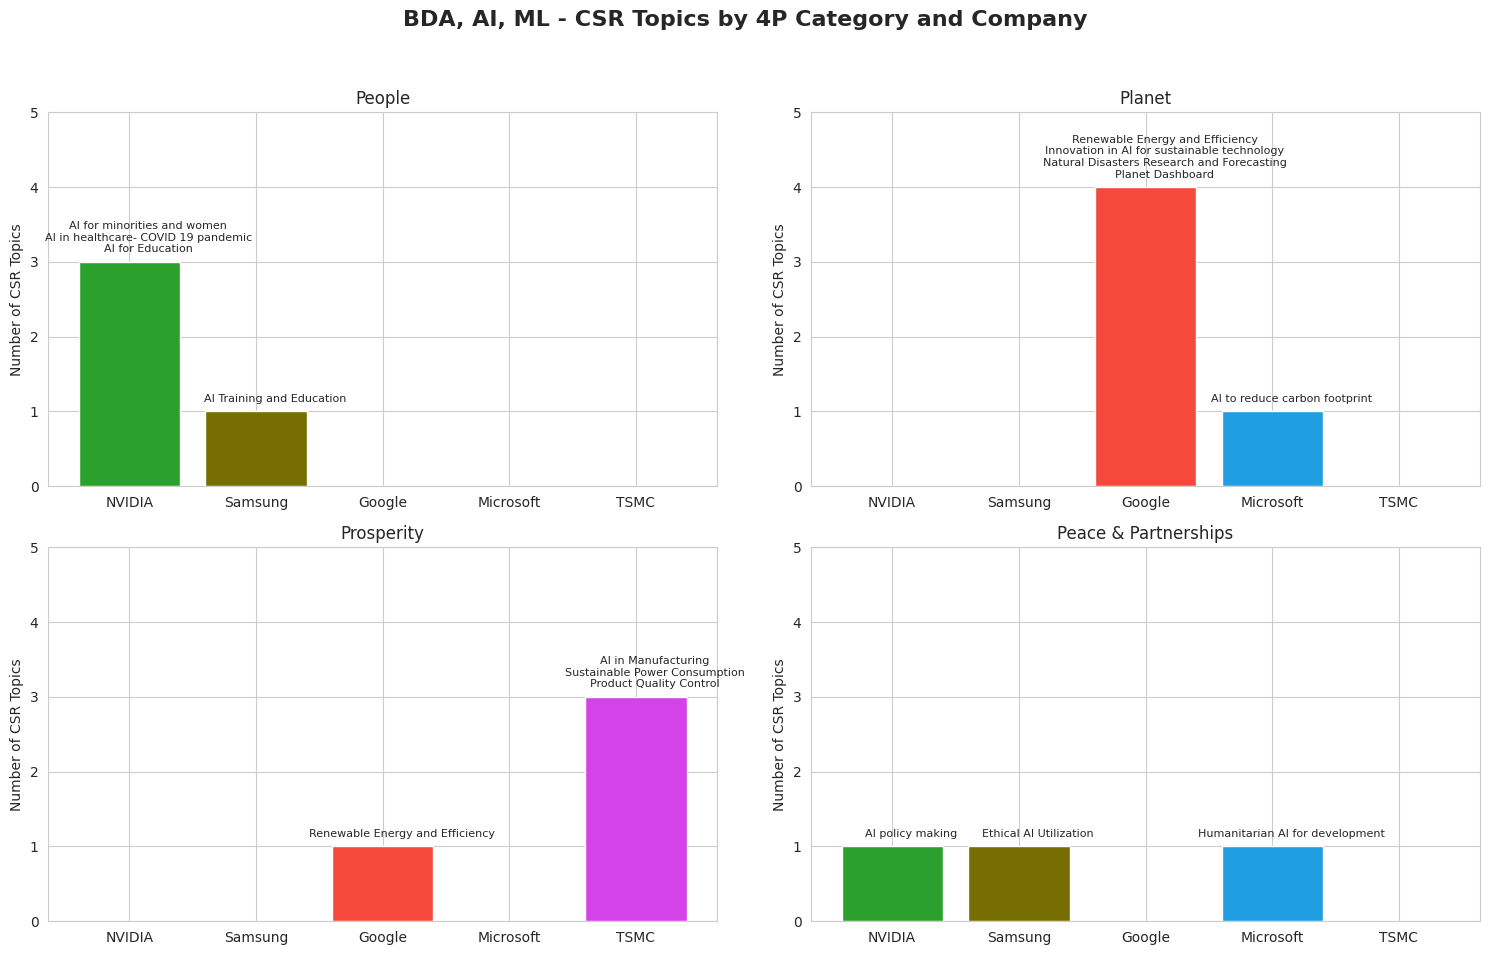

In [140]:
#Visualise number of topics generated by topic modelling
import matplotlib.pyplot as plt
import pandas as pd

data = {
    "4P-Category": ["People", "Planet", "Prosperity", "Peace & Partnerships"],
    "NVIDIA": [
        "AI for minorities and women, AI in healthcare- COVID 19 pandemic, AI for Education",
        "",
        "",
        "AI policy making"
    ],
    "Samsung": [
        "AI Training and Education",
        "",
        "",
        "Ethical AI Utilization"
    ],
    "Google": [
        "",
        "Renewable Energy and Efficiency, Innovation in AI for sustainable technology, Natural Disasters Research and Forecasting, Planet Dashboard",
        "Renewable Energy and Efficiency",
        ""
    ],
    "Microsoft": [
        "",
        "AI to reduce carbon footprint",
        "",
        "Humanitarian AI for development"
    ],
    "TSMC": [
        "",
        "",
        "AI in Manufacturing, Sustainable Power Consumption, Product Quality Control",
        ""
    ]
}


df = pd.DataFrame(data)

colors = {
    "NVIDIA": "#2ca02c",
    "Google": "#F4493B",
    "Microsoft": "#209EE2",
    "Samsung": "#766E00",
    "TSMC": "#D343E7"
}


def create_bar_chart_with_topics(ax, category, companies, topics, colors):
    values = [len(topics[j].split(',')) if topics[j] else 0 for j in range(len(companies))]
    bars = ax.bar(companies, values, color=[colors[company] for company in companies])


    for bar, topic in zip(bars, topics):
        height = bar.get_height()
        if height > 0:
            ax.text(
                (bar.get_x() + bar.get_width() / 2)+0.15,
                height+0.1,
                '\n'.join(topic.split(', ')),
                ha='center', va='bottom', fontsize=8
            )

    ax.set_title(category)
    ax.set_ylabel('Number of CSR Topics')
    ax.set_ylim(0, 5)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle('BDA, AI, ML - CSR Topics by 4P Category and Company', fontsize=16, fontweight='bold')

categories = df["4P-Category"].tolist()
companies = df.columns[1:].tolist()

for i, ax in enumerate(axes.flatten()):
    category = categories[i]
    topics = [df.iloc[i, j] for j in range(1, len(df.columns))]
    create_bar_chart_with_topics(ax, category, companies, topics, colors)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
